In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import skfolio
from skfolio import BasePortfolio, RatioMeasure
import seaborn as sns
from skimpy import skim
import plotly.graph_objects as go
from feature_engineer import engineer_features_and_labels

#metrics, scalers, validations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import(
    StandardScaler,
    LabelEncoder,
    RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency


#Models to test
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Export Model
import joblib
import pickle

from warnings import filterwarnings
filterwarnings("ignore")
plt.style.use("ggplot")

In [3]:
#Training Set
df = pd.read_csv("nifty50_training_set.csv")


df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'oi'], dtype='object')

In [4]:
df = engineer_features_and_labels(df)

In [5]:
#checking for null values
df.isnull().sum()

datetime        0
open            0
high            0
low             0
close           0
volume          0
oi              0
ema_dist        0
ema9_angle      0
ema15_angle     0
trend_up        0
candle_body     0
body_ratio      0
is_pin_bar      0
is_full_body    0
is_big_bar      0
touch_ema9      0
touch_ema15     0
is_flat         0
target          0
dtype: int64

In [6]:
#Better Description for the data
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 197586 │ │ float64     │ 10    │                                                          │
│ │ Number of columns │ 20     │ │ int64       │ 9     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column         ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0      ┃ p25     ┃ p50     ┃ p75     ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ open           │   0 │     0 │    14220 │    5483 │    6874 │    9666 │   11820 │   18040 │ 26270 │ ██▃▅▂▃ │  │
│ │ high           │   0 │     0 │    14230 │    5485 │    6896 │    9669 │   11820 │   18050 │ 26280 │ ██▂▅▂▃ │  │
│ │ low            │   0 │     0 │    14210 │    5481 │    6826 │    9663 │   11810 │   18030 │ 26270 │ ██▃▅▂▃ │  │
│ │ close          │   0 │     0 │    14220 │    5483 │    6874 │    9666 │   11810 │   18040 │ 26270 │ ██▂▅▂▃ │  │
│ │ volume         │   0 │     0 │        0 │       0 │       0 │       0 │       0 │       0 │     0 │     █  │  │
│ │ oi             │   0 │     0 │        0 │       0 │       0 │       0 │       0 │       0 │     0 │     █  │  │
│ │ ema_dist       │   0 │     0 │   0.2677 │   9.514 │  -177.2 │  -3.235 │  0.3889 │    3.99 │ 120.2 │     █  │  │
│ │ ema9_angle     │   0 │     0 │    4.211 │   73.05 │  -89.87 │  -77.28 │   23.95 │   79.12 │ 89.81 │ ▇▁▁▁▁█ │  │
│ │ ema15_angle    │   0 │     0 │    4.566 │   71.16 │  -89.81 │  -74.82 │   22.51 │   77.37 │ 89.72 │ ▇▂▁▁▂█ │  │
│ │ trend_up       │   0 │     0 │    0.533 │  0.4989 │       0 │       0 │       1 │       1 │     1 │ ▇    █ │  │
│ │ candle_body    │   0 │     0 │  -0.1218 │   12.48 │  -349.4 │   -4.95 │     0.1 │    5.05 │ 560.3 │    █   │  │
│ │ body_ratio     │   0 │     0 │   0.4888 │  0.2706 │       0 │  0.2623 │  0.4947 │  0.7122 │     1 │ ▆▇██▇▅ │  │
│ │ is_pin_bar     │   0 │     0 │   0.2608 │  0.4391 │       0 │       0 │       0 │       1 │     1 │ █    ▃ │  │
│ │ is_full_body   │   0 │     0 │   0.2635 │  0.4405 │       0 │       0 │       0 │       1 │     1 │ █    ▃ │  │
│ │ is_big_bar     │   0 │     0 │   0.3996 │  0.4898 │       0 │       0 │       0 │       1 │     1 │ █    ▅ │  │
│ │ touch_ema9     │   0 │     0 │   0.4498 │  0.4975 │       0 │       0 │       0 │       1 │     1 │ █    ▇ │  │
│ │ touch_ema15    │   0 │     0 │   0.3109 │  0.4629 │       0 │       0 │       0 │       1 │     1 │ █    ▄ │  │
│ │ is_flat        │   0 │     0 │      0.2 │     0.4 │       0 │       0 │       0 │       0 │     1 │ █    ▂ │  │
│ │ target         │   0 │     0 │    2.005 │  0.5976 │       0 │       2 │       2 │       2 │     4 │     █  │  │
│ └────────────────┴─────┴───────┴──────────┴─────────┴─────────┴─────────┴─────────┴─────────┴───────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━

In [7]:
df

datetime      open      high       low     close  \
0      2015-01-09 09:30:00+05:30   8294.10   8295.75   8280.65   8288.50   
1      2015-01-09 09:35:00+05:30   8289.10   8290.45   8278.00   8283.45   
2      2015-01-09 09:40:00+05:30   8283.40   8288.30   8277.40   8285.55   
3      2015-01-09 09:45:00+05:30   8285.40   8287.65   8278.05   8283.75   
4      2015-01-09 09:50:00+05:30   8283.80   8284.25   8273.95   8276.25   
...                          ...       ...       ...       ...       ...   
197581 2025-09-15 15:00:00+05:30  25083.20  25091.05  25074.85  25079.00   
197582 2025-09-15 15:05:00+05:30  25078.45  25079.60  25067.95  25069.00   
197583 2025-09-15 15:10:00+05:30  25068.70  25072.10  25064.75  25067.10   
197584 2025-09-15 15:15:00+05:30  25067.10  25068.05  25060.70  25065.10   
197585 2025-09-15 15:20:00+05:30  25065.05  25068.10  25061.55  25065.70   

        volume  oi  ema_dist  ema9_angle  ema15_angle  trend_up  candle_body  \
0            0   0 -1.315866  -74.850990   -67.189915         0        -5.60   
1            0   0 -2.205612  -81.207065   -76.832028         0        -5.65   
2            0   0 -2.615795  -81.744126   -78.267317         0         2.15   
3            0   0 -2.972528  -81.205248   -78.248041         0        -1.65   
4            0   0 -3.710428  -81.398240   -78.918998         0        -7.55   
...        ...  ..       ...         ...          ...       ...          ...   
197581       0   0 -0.912693    0.484800   -16.353888         0        -4.20   
197582       0   0 -1.872285  -76.303425   -70.510201         0        -9.45   
197583       0   0 -2.639692  -81.400503   -77.614018         0        -1.60   
197584       0   0 -3.260885  -82.936218   -80.086661         0        -2.00   
197585       0   0 -3.569197  -82.000759   -79.544762         0         0.65   

        body_ratio  is_pin_bar  is_full_body  is_big_bar  touch_ema9  \
0         0.370861           0             0           0           0   
1         0.453815           0             0           0           0   
2         0.197248           1             0           0           0   
3         0.171875           1             0           0           0   
4         0.733010           0             1           0           0   
...            ...         ...           ...         ...         ...   
197581    0.259259           0             0           1           1   
197582    0.811159           0             1           0           0   
197583    0.217687           1             0           0           0   
197584    0.272109           1             0           0           0   
197585    0.099237           1             0           0           0   

        touch_ema15  is_flat  target  
0                 0        0     2.0  
1                 0        0     2.0  
2                 0        0     2.0  
3                 0        0     2.0  
4                 0        0     2.0  
...             ...      ...     ...  
197581            1        1     2.0  
197582            0        1     2.0  
197583            0        1     2.0  
197584            0        1     2.0  
197585            0        1     2.0  

[197586 rows x 20 columns]

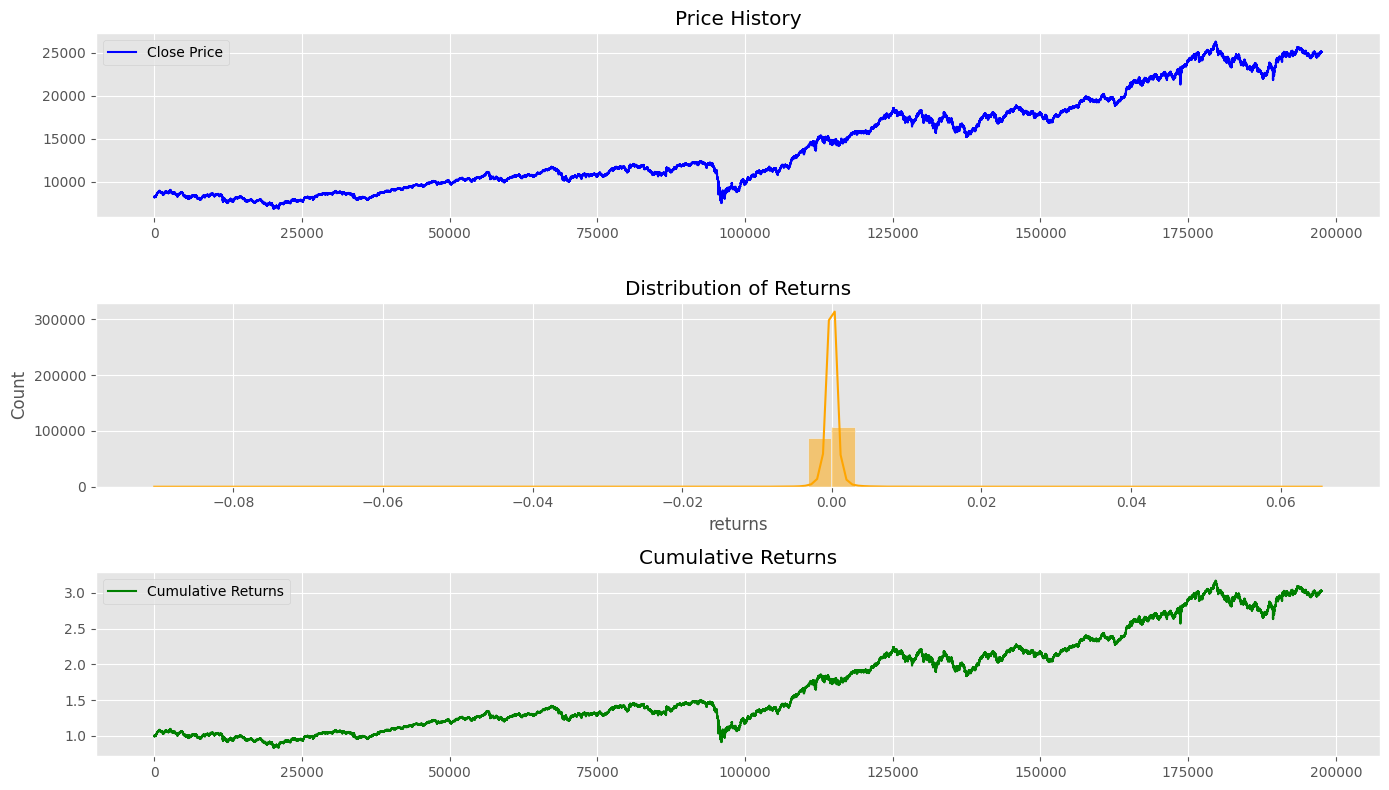

Performance Statistics:
                             0
Mean Return (annual)  0.001576
Volatility (annual)   0.018133
Sharpe Ratio          0.086939
Max Drawdown         -0.391505


In [8]:
# Load your data (assuming it's already a DataFrame df)
# Columns: ['datetime','open','high','low','close','volume','oi']

df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate returns
df['returns'] = df['close'].pct_change().fillna(0)
df['cum_returns'] = (1 + df['returns']).cumprod()

# Rolling Sharpe (window 60 days)
rolling_window = 60
rolling_sharpe = df['returns'].rolling(rolling_window).mean() / df['returns'].rolling(rolling_window).std()
rolling_sharpe *= np.sqrt(252)  # annualize

# Key statistics
mean_return = df['returns'].mean() * 252
volatility = df['returns'].std() * np.sqrt(252)
sharpe_ratio = mean_return / volatility if volatility != 0 else np.nan
max_drawdown = (df['cum_returns'] / df['cum_returns'].cummax() - 1).min()

stats = pd.DataFrame({
    "Mean Return (annual)": [mean_return],
    "Volatility (annual)": [volatility],
    "Sharpe Ratio": [sharpe_ratio],
    "Max Drawdown": [max_drawdown]
}).T

# -------- Plot Section -------- #

plt.figure(figsize=(14, 8))

# Price chart
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.title("Price History")
#plt.savefig("Price History.png")
plt.legend()

# Returns histogram
plt.subplot(3, 1, 2)
sns.histplot(df['returns'], bins=50, kde=True, color="orange")
#plt.savefig("Distribution of Returns.png")
plt.title("Distribution of Returns")

# Cumulative returns
plt.subplot(3, 1, 3)
plt.plot(df.index, df['cum_returns'], label='Cumulative Returns', color='green')
plt.title("Cumulative Returns")
#plt.savefig("Cumulative Returns.png")
plt.legend()

plt.tight_layout()
plt.show()

# Interactive Rolling Sharpe
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=rolling_sharpe, mode='lines', name='Rolling Sharpe'))
fig.update_layout(title="Rolling Sharpe Ratio (60-day window)", xaxis_title="Date", yaxis_title="Sharpe Ratio")
fig.show()

# Display stats table
print("Performance Statistics:")
print(stats)

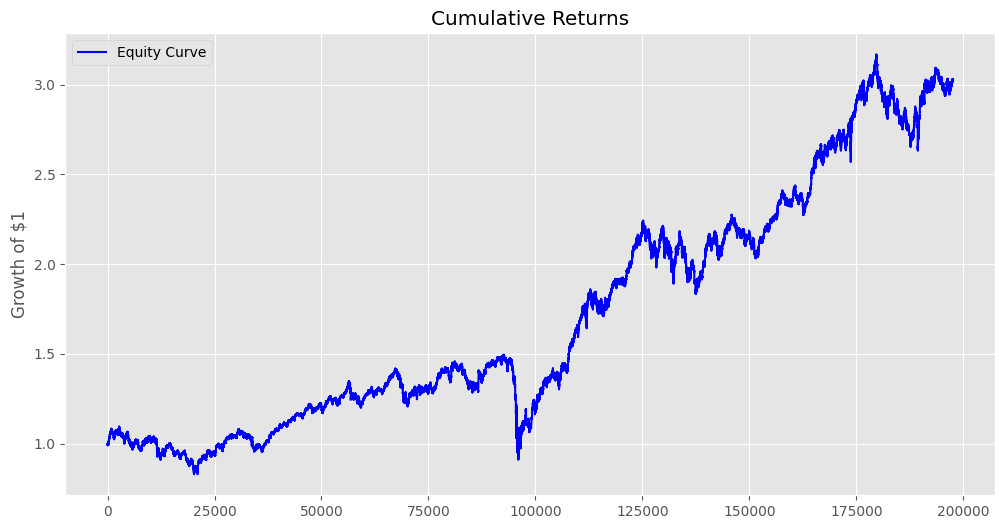

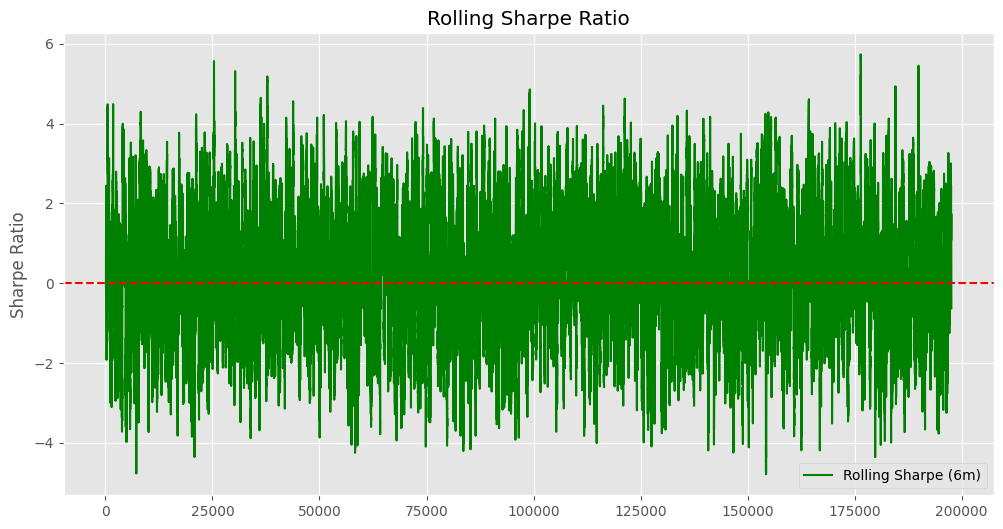

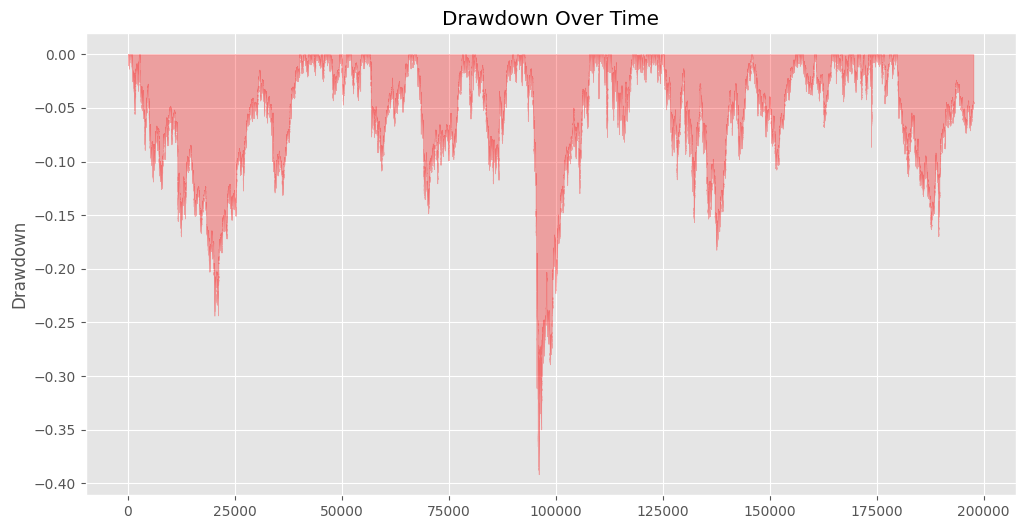

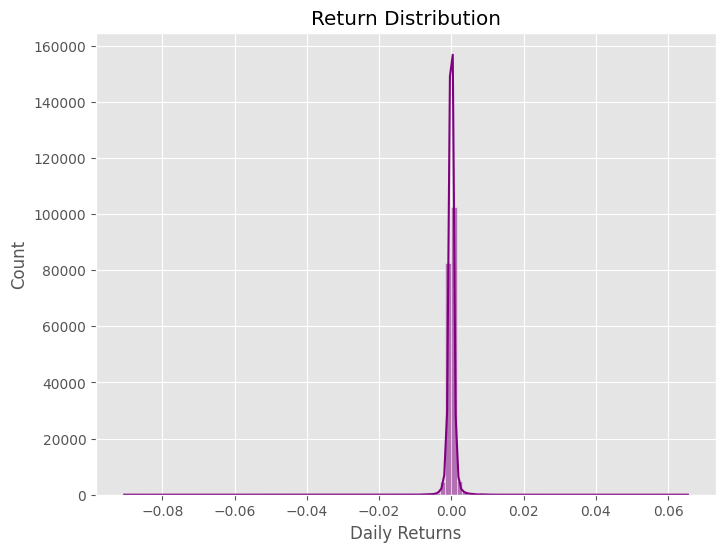

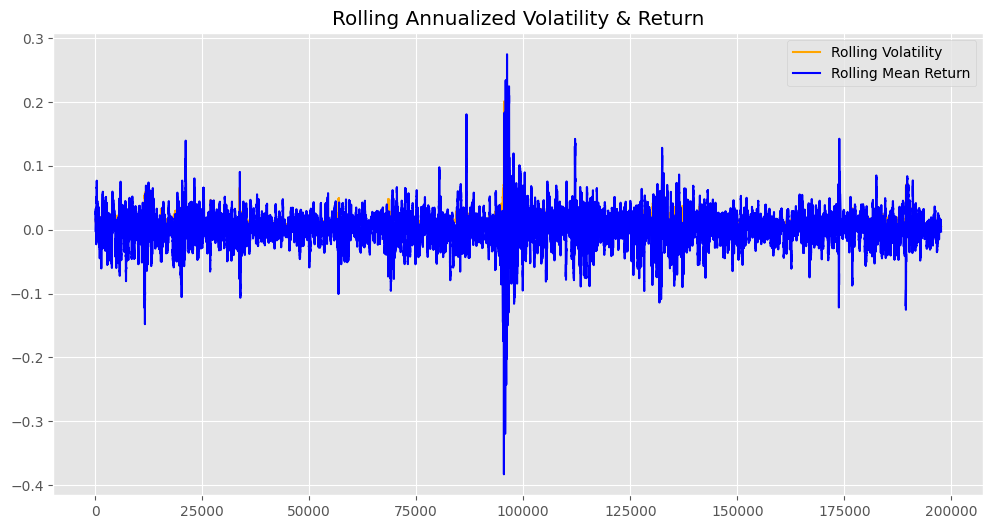

In [9]:
# Assume df has 'close' and datetime index
df['returns'] = df['close'].pct_change()
df['cum_returns'] = (1 + df['returns']).cumprod()

# Rolling metrics
window = 126  # ~6 months for daily data
df['rolling_sharpe'] = (df['returns'].rolling(window).mean() /
                        df['returns'].rolling(window).std()) * np.sqrt(252)
df['drawdown'] = df['cum_returns'] / df['cum_returns'].cummax() - 1

# --- Plot 1: Equity Curve ---
plt.figure(figsize=(12,6))
plt.plot(df.index, df['cum_returns'], label="Equity Curve", color="blue")
plt.title("Cumulative Returns")
plt.ylabel("Growth of $1")
plt.legend()
#plt.savefig("Equity Curve.png")
plt.show()

# --- Plot 2: Rolling Sharpe ---
plt.figure(figsize=(12,6))
plt.plot(df.index, df['rolling_sharpe'], label="Rolling Sharpe (6m)", color="green")
plt.axhline(0, color="red", linestyle="--")
plt.title("Rolling Sharpe Ratio")
plt.ylabel("Sharpe Ratio")
plt.legend()
#plt.savefig("Rolling Sharpe.png")
plt.show()

# --- Plot 3: Drawdown ---
plt.figure(figsize=(12,6))
plt.fill_between(df.index, df['drawdown'], 0, color="red", alpha=0.3)
plt.title("Drawdown Over Time")
plt.ylabel("Drawdown")
#plt.savefig("Drawdown over time.png")
plt.show()

# --- Plot 4: Return Distribution ---
plt.figure(figsize=(8,6))
sns.histplot(df['returns'].dropna(), bins=100, kde=True, color="purple")
plt.title("Return Distribution")
plt.xlabel("Daily Returns")
#plt.savefig("Daily Returns.png")
plt.show()

# --- Plot 5: Volatility vs Returns ---
plt.figure(figsize=(12,6))
rolling_vol = df['returns'].rolling(window).std() * np.sqrt(252)
plt.plot(df.index, rolling_vol, label="Rolling Volatility", color="orange")
plt.plot(df.index, df['returns'].rolling(window).mean()*252, label="Rolling Mean Return", color="blue")
plt.title("Rolling Annualized Volatility & Return")
plt.legend()
#plt.savefig("Rolling Annualized Volatility.png")
plt.show()

## NOW WE find the best parameter to model the strategy

In [10]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'oi', 'ema_dist',
       'ema9_angle', 'ema15_angle', 'trend_up', 'candle_body', 'body_ratio',
       'is_pin_bar', 'is_full_body', 'is_big_bar', 'touch_ema9', 'touch_ema15',
       'is_flat', 'target', 'returns', 'cum_returns', 'rolling_sharpe',
       'drawdown'],
      dtype='object')

In [11]:
def preprocess_for_sklearn(X, y=None, apply_smote=False):
    X_processed = X.copy()

    # Handle data types
    for col in X_processed.columns:
        if pd.api.types.is_datetime64_any_dtype(X_processed[col]):
            X_processed[col] = X_processed[col].astype('int64') // 10**9
        elif X_processed[col].dtype == 'object':
            try:
                datetime_col = pd.to_datetime(X_processed[col])
                X_processed[col] = datetime_col.astype('int64') // 10**9
            except (ValueError, TypeError):
                X_processed[col] = pd.factorize(X_processed[col])[0]

    # Fill missing values
    X_processed = X_processed.fillna(X_processed.mean())

    # Optionally apply SMOTE
    if apply_smote and y is not None:
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_res, y_res = smote.fit_resample(X_processed, y)
        return X_res, y_res

    return X_processed, y



In [12]:
X = df.drop("target", axis=1)
y = df["target"]

# Preprocess without SMOTE
#X_proc, y_proc = preprocess_for_sklearn(X, y, apply_smote=False) #Original: (197586, 23)

# Preprocess with SMOTE balancing
X_balanced, y_balanced = preprocess_for_sklearn(X, y, apply_smote=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [15]:
pipeline = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("clf", XGBClassifier(
    # Core boosting settings
    booster="gbtree",
    n_estimators=1000,        # large trees, let early_stopping control
    learning_rate=0.03,       # small LR + many trees works best
    max_depth=6,              # balance complexity vs overfitting
    min_child_weight=5,       # prevent overfitting small samples
    gamma=1,                  # minimum loss reduction for split

    # Column & row sampling (regularization by randomness)
    subsample=0.8,            # row sampling
    colsample_bytree=0.8,     # feature sampling

    # Regularization (shrinkage)
    reg_alpha=0.1,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization

    # Imbalanced data handling
    scale_pos_weight=1,       # adjust if imbalance ratio is extreme

    # Multi-class
    objective="multi:softprob",
    eval_metric="mlogloss",

    # Efficiency
    tree_method="hist",       # fast for large datasets
    random_state=42,
    n_jobs=-1
))
])

pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.8,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=1, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=None, ...))])

In [16]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

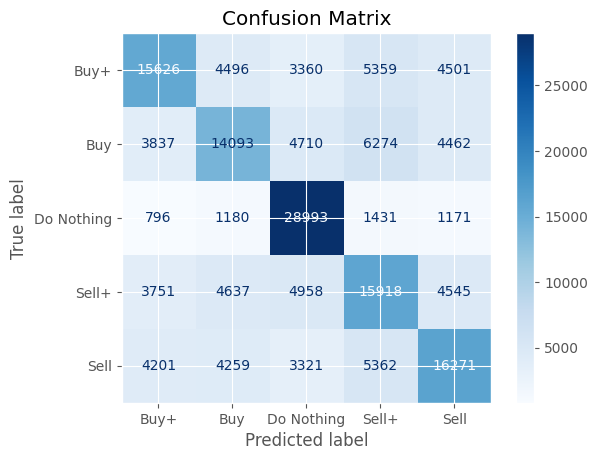

In [19]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buy+', 'Buy', 'Do Nothing', 'Sell+', 'Sell'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig("Confusion Matrix.png")
plt.show()

In [20]:
print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=['Buy+', 'Buy', 'Do Nothing', 'Sell+', 'Sell']))

Classification Report:
              precision    recall  f1-score   support

        Buy+       0.55      0.47      0.51     33342
         Buy       0.49      0.42      0.45     33376
  Do Nothing       0.64      0.86      0.73     33571
       Sell+       0.46      0.47      0.47     33809
        Sell       0.53      0.49      0.51     33414

    accuracy                           0.54    167512
   macro avg       0.53      0.54      0.53    167512
weighted avg       0.53      0.54      0.53    167512



In [21]:
cm = confusion_matrix(Y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

chi2, p, dof, expected = chi2_contingency(cm)
print(f"\nChi-square Test on Confusion Matrix: chi2={chi2:.3f}, p={p:.5f}, dof={dof}")


Confusion Matrix:
 [[15626  4496  3360  5359  4501]
 [ 3837 14093  4710  6274  4462]
 [  796  1180 28993  1431  1171]
 [ 3751  4637  4958 15918  4545]
 [ 4201  4259  3321  5362 16271]]

Chi-square Test on Confusion Matrix: chi2=133807.849, p=0.00000, dof=16


In [23]:
from scipy.stats import chi2_contingency
from sklearn.metrics import cohen_kappa_score

#just seeing some stats test
conf_matrix = np.array([
  [15626, 4496, 3360,  5359,  4501],
  [ 3837, 14093,  4710,  6274,  4462],
  [  796,  1180, 28993,  1431,  1171],
  [ 3751,  4637,  4958, 15918,  4545],
  [ 4201,  4259,  3321,  5362, 16271]])
# ---- Chi-square & Cramér’s V ----
chi2, p, dof, expected = chi2_contingency(conf_matrix)
n = conf_matrix.sum()  # total samples
phi2 = chi2 / n
r, k = conf_matrix.shape
cramers_v = np.sqrt(phi2 / min(r - 1, k - 1))

print(f"Chi-square: {chi2:.3f}, p-value: {p:.5f}, dof: {dof}")
print(f"Cramér’s V: {cramers_v:.3f}")

# ---- Cohen’s Kappa ----
# Need to expand confusion matrix into label vectors
y_true = []
y_pred = []
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        y_true += [i] * conf_matrix[i, j]
        y_pred += [j] * conf_matrix[i, j]

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen’s Kappa: {kappa:.3f}")

Chi-square: 133807.849, p-value: 0.00000, dof: 16
Cramér’s V: 0.447
Cohen’s Kappa: 0.428


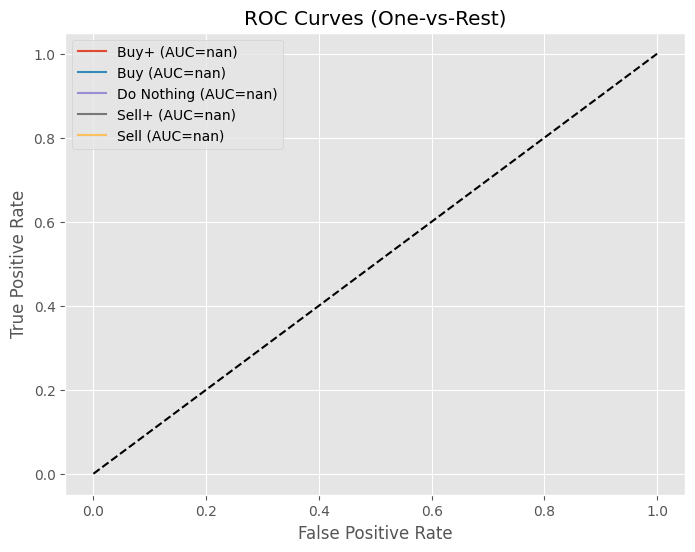

In [24]:
classes =['Buy+', 'Buy', 'Do Nothing', 'Sell+', 'Sell']

# =======================
# ROC Curve + AUC (One-vs-Rest)
# =======================
# Binarize labels
y_test_bin = label_binarize(Y_test, classes=classes)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("ROC Curves (One-vs-Rest).png")
plt.legend()
plt.show()

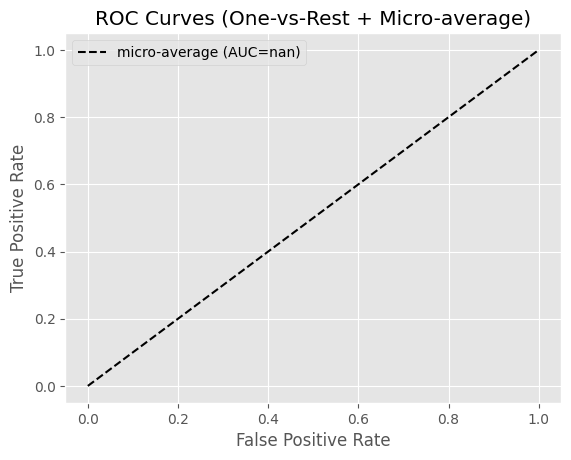

In [25]:
# Micro-average ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label=f"micro-average (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves (One-vs-Rest + Micro-average)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("ROC Curves (One-vs-Rest + Micro-average).png")
plt.legend()
plt.show()


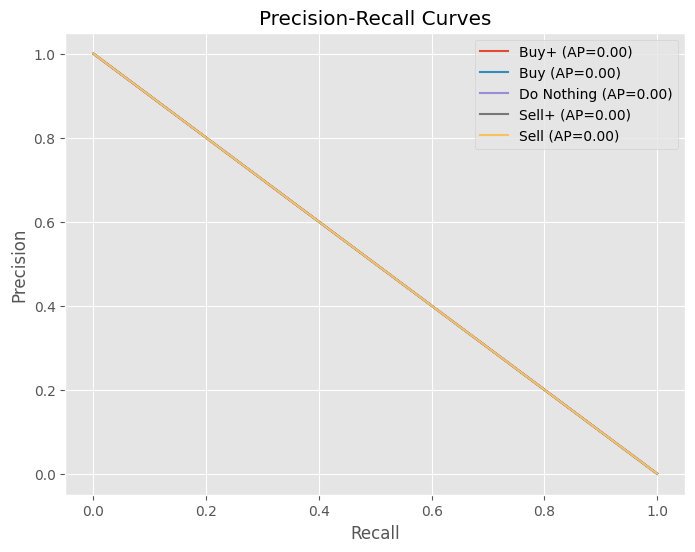

In [26]:
# =======================
# Precision-Recall Curves
# =======================
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    avg_prec = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f"{classes[i]} (AP={avg_prec:.2f})")

plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("Precision-Recall Curves.png")
plt.legend()
plt.show()


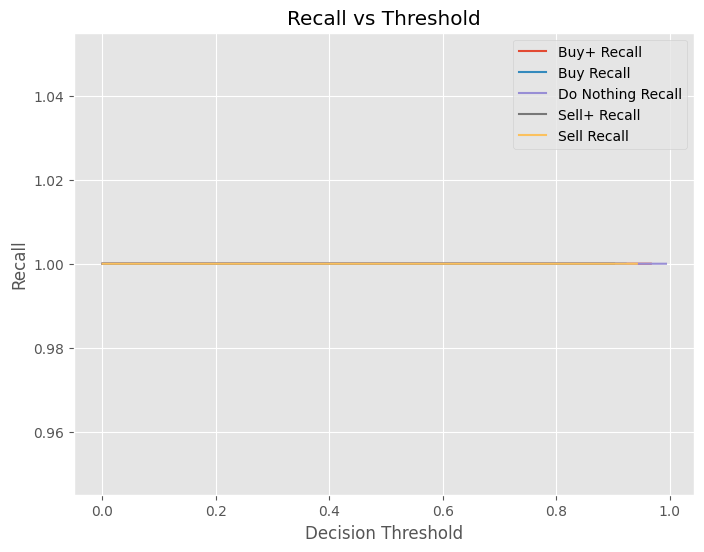

In [27]:
# =======================
# Recall Curve (per class)
# =======================
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(thresholds, recall[:-1], label=f"{classes[i]} Recall")

plt.title("Recall vs Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Recall")
plt.legend()
plt.savefig("Recall vs Threshold.png")
plt.show()

In [38]:
#Simulated Strategy
#Mapping labels to trading direction
prices = df['close'].values

# Percentage returns
returns = np.diff(prices) / prices[:-1]
returns = returns[:len(y_pred_action)]
label_to_action = {
    0: 1,   # Buy+
    1: 1,   # Buy
    2: 0,   # Do Nothing
    3: -1,  # Sell
    4: -1   # Sell+
}
# Convert predictions and actuals into trade directions
y_pred_action = np.array([label_to_action[label] for label in y_pred])
y_true_action = np.array([label_to_action[label] for label in y_true])

# Simulated P&L: prediction * actual return
# (e.g., predict long (1) → gain if return >0, loss if <0)
pnl = y_pred_action * returns

# Metrics
total_return = pnl.sum()
avg_return = pnl.mean()
win_rate = (pnl > 0).mean()
sharpe_ratio = pnl.mean() / pnl.std()

print(f"Total Return: {total_return:.4f}")
print(f"Average Return per Trade: {avg_return:.4f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Return: -0.2666
Average Return per Trade: -0.0000
Win Rate: 36.25%
Sharpe Ratio: -0.00


In [42]:
joblib.dump(pipeline, "xgb_model.pkl")

['xgb_model.pkl']